In [1]:
# load standard python modules
import argparse
from datetime import datetime
import copy
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from src.models.jjepa import JJEPA
from src.options import Options
from src.dataset.JetDataset import JetDataset

In [2]:
from src.evaluation.finetune import load_data, load_model, Projector

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

## Configure Paths and Variables

In [4]:
args = argparse.Namespace(
    batch_size = 2048,
    test_dataset_path = "/j-jepa-vol/J-JEPA/data/top/val/val_20_30.h5",
    option_file = "/j-jepa-vol/J-JEPA/options/NLDR_ViT_L.json",
    load_pretrain_jjepa_path = "/j-jepa-vol/J-JEPA/models/JetClass/mask_output/NLDR/best_model.pth",
    load_finetune_jjepa_path = "/j-jepa-vol/J-JEPA/model_performances/JetClass/mask_output/full-top/NLDR_flatten/trial-0/jjepa_finetune_best_rej.pt",
    load_proj_path = "/j-jepa-vol/J-JEPA/model_performances/JetClass/mask_output/full-top/NLDR_flatten/trial-0/projector_finetune_best_rej.pt",
    out_dir = "/j-jepa-vol/J-JEPA-billy/plots/conf_roc_042025",
    small = False,
    device = 'cuda',
    old = False,
    from_checkpoint = False,
    cls = False,
    flatten = True,
)

## Get Dataloader

In [5]:
test_dataloader = load_data(args, args.test_dataset_path, "test")

Initializing JetDataset with file: /j-jepa-vol/J-JEPA/data/top/val/val_20_30.h5
Loading features and subjets from HDF5 file
Filtered to 261239 good jets
Final dataset size: 261239 jets
__getitem__ returns (x, particle_features, subjets, indices, subjet_mask, particle_mask, labels)


## Load Target Transformer

In [6]:
options = Options.load(args.option_file)

In [7]:
# Create the directory
os.makedirs(args.out_dir, exist_ok=True)

In [8]:
args.logfile = f"{args.out_dir}/dev_confusion_matrix_orc.txt"
logfile = open(args.logfile, "a")

In [9]:
model = load_model(
    args, logfile, options, args.load_pretrain_jjepa_path, args.device, old=args.old,
)
net = model.target_transformer

In [10]:
net.load_state_dict(torch.load(args.load_finetune_jjepa_path, map_location=args.device))

<All keys matched successfully>

## Load Projectors

In [11]:
args.output_dim = options.emb_dim
args.output_dim *= 20
finetune_mlp_dim = args.output_dim

In [12]:
proj = Projector(2, finetune_mlp_dim).to(args.device)

In [13]:
proj.load_state_dict(torch.load(args.load_proj_path, map_location=args.device))

<All keys matched successfully>

## Get Predictions

In [15]:
pbar = tqdm.tqdm(test_dataloader)
need_particle_masks = "att" in options.embedding_layers_type.lower()
softmax = torch.nn.Softmax(dim=1)


  0%|                                                                                                                                     | 0/128 [00:23<?, ?it/s]


In [16]:
y_pred = []
y_truth = []
for i, (x, _, subjets, _, subjet_mask, particle_masks, labels) in enumerate(pbar):
    y = labels.to(args.device)
    subjet_mask = subjet_mask.to(args.device)
    x = x.view(x.shape[0], x.shape[1], -1)
    x = x.to(args.device)
    batch = {"particles": x.to(torch.float32)}
    reps = net(
        batch,
        subjet_mask,
        subjets_meta=subjets.to(args.device),
        particle_masks=(
            particle_masks.to(args.device) if need_particle_masks else None
        ),
        split_mask=None,
    )
    if not args.cls:
        if args.flatten:
            reps = reps.view(reps.shape[0], -1)
        elif args.sum:
            reps = reps.sum(dim=1)
        else:
            raise ValueError("No aggregation method specified")
        out = proj(reps)
    else:
        out = proj(reps.transpose(0, 1), padding_mask=subjet_mask == 0)
    y_pred.append(softmax(out).cpu().data.numpy())
    y_truth.append(y.cpu().numpy())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [02:26<00:00,  1.14s/it]


In [17]:
truth = np.concatenate(y_truth, axis=0)
score = np.concatenate(y_pred, axis=0)
pred = score[:,1]>0.5

## Plot Confusion Matrix

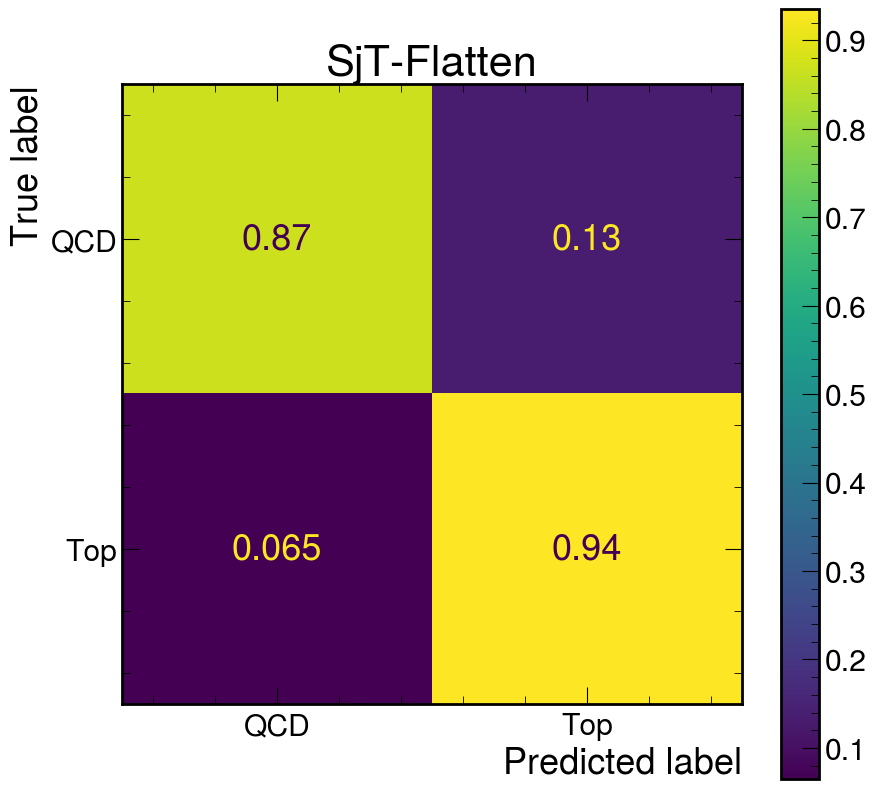

In [76]:
cm = confusion_matrix(truth, pred, normalize='true', labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["QCD", "Top"])
disp.plot()
plt.title("SjT-Flatten")
plt.savefig(f'{args.out_dir}/confusion_matrix.pdf', format='pdf')
plt.savefig(f'{args.out_dir}/confusion_matrix.png')

## Plot Roc Curve

In [26]:
fpr, tpr, thresholds = roc_curve(truth, score[:,1])
roc_auc = auc(fpr, tpr)

In [43]:
import mplhep as hep
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

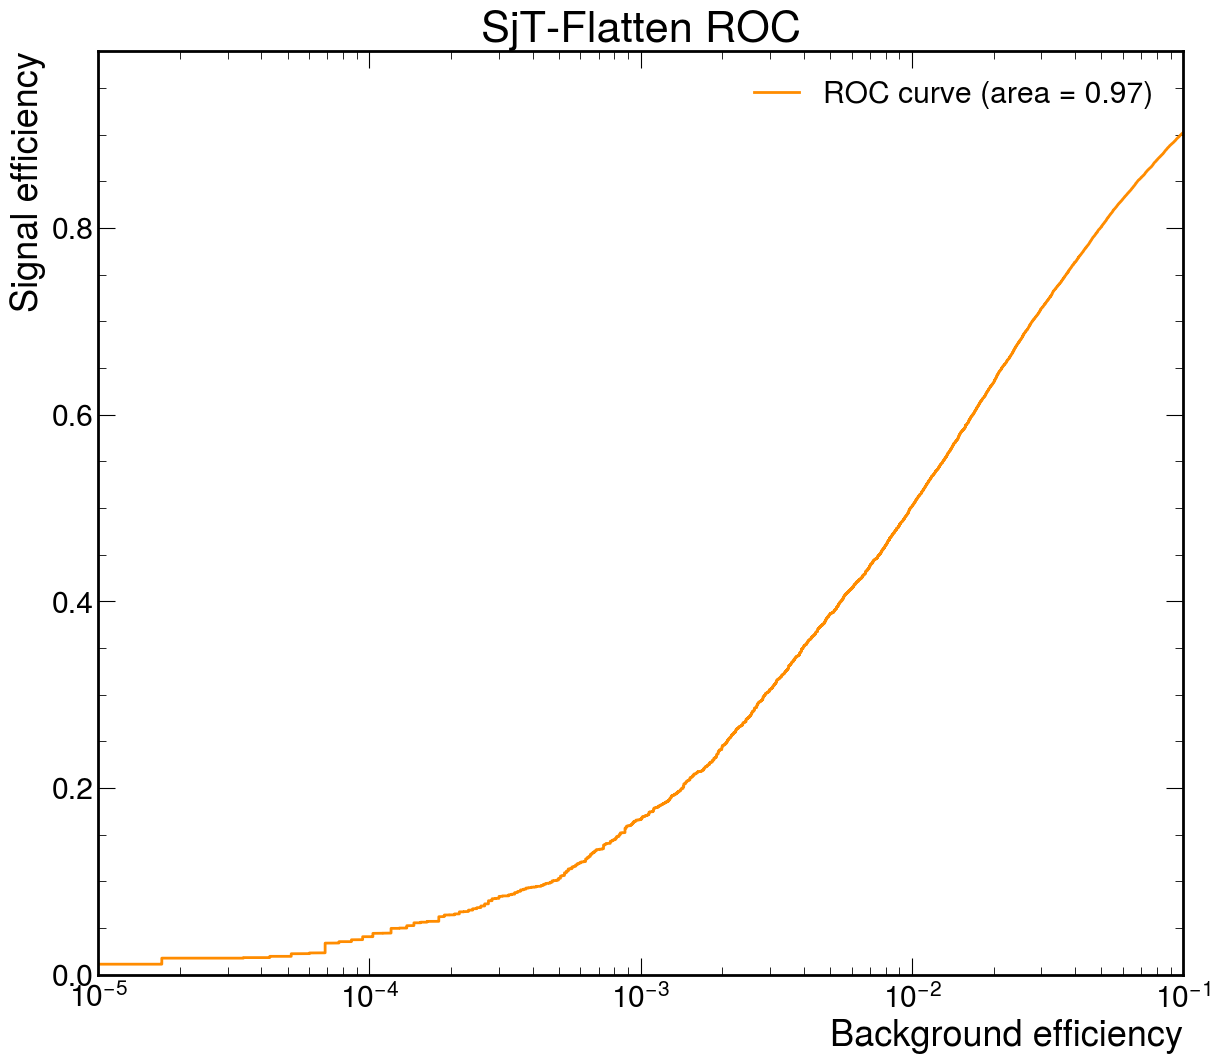

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
lw = 2
ax.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
ax.set(
    xlim=[1e-5, 1e-1],
    ylim=[0, 0.99],
    title="SjT-Flatten ROC",
    xlabel='Background efficiency',
    ylabel="Signal efficiency"
)
ax.set_xscale("log")
ax.legend()
plt.savefig(f"{args.out_dir}/roc.pdf", format='pdf')
plt.savefig(f"{args.out_dir}/roc.png")

In [68]:
args.out_dir

'/j-jepa-vol/J-JEPA-billy/plots/conf_roc_042025'